<a href="https://colab.research.google.com/github/Ansuman09/Amazon-Stock-Analysis/blob/main/InvestmentTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime as dt

df=pd.read_csv('AMZN.csv')

## Processing the Data

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-16,49.799999,49.987499,49.099998,49.385502,49.385502,229454000
1,2017-06-19,50.849998,50.849998,49.494999,49.758499,49.758499,100868000
2,2017-06-20,49.900002,50.243999,49.601002,49.629501,49.629501,81536000
3,2017-06-21,49.935001,50.136002,49.632500,50.111500,50.111500,58450000
4,2017-06-22,50.111500,50.348000,49.860001,50.064999,50.064999,45068000


In [ ]:
df['Date']=pd.to_datetime(df['Date'])

#Let's Findout the number of days the data was recorded in a month

years=[2017,2018,2019,2020,2021,2022]

def calculate_days_in_month(data,years):
  '''
  This function will give the list of days in a month for each year
  -> The date series must be in datetime format
  -> the years needs to be passed as a list'''

  days_in_month=[]
  for year in years:
    year_data=data[data['Date'].dt.year==year]
    for month in range(1,13):
      days=year_data[year_data['Date'].dt.month==month].shape[0]
      days_in_month.append(days)
  return days_in_month


# we remove the first 6 months in 2017 and last 6 months of 2022 because the data is incomplete or absent
days_in_month=calculate_days_in_month(df,years)
days_in_month=days_in_month[6:-7]
 
print(f'The number of days the data was recorded in each month :{days_in_month}')
print(f'Avg number of days the data was reorded: {round(sum(days_in_month)/len(days_in_month))}')

The number of days the data was recorded in each month :[20, 23, 20, 22, 21, 20, 21, 19, 21, 21, 22, 21, 21, 23, 19, 23, 21, 19, 21, 19, 21, 21, 22, 20, 22, 22, 20, 23, 20, 21, 21, 19, 22, 21, 20, 22, 22, 21, 21, 22, 20, 22, 19, 19, 23, 21, 20, 22, 21, 22, 21, 21, 21, 22, 20, 19, 23, 20, 21]
Avg number of days the data was reorded: 21


In [ ]:
#The model will use Closing Price as train price

split_lim=round(.75*df.shape[0])
train_data=df['Close'][:split_lim]
train_time=df.Date[:split_lim]


X_test=df['Close'][split_lim:]
test_time=df.Date[split_lim:]

In [ ]:
def create_tf_data(series,window_size,batch_size,shuffle_buffer=None):
  '''the following code takes a series as the input data and 
  converts it into a dataset that has features of length window_size 
  and the successing point in the series as its output
  
  example: [1,2,3] --> [1,2] [3]'''

  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda window : window.batch(window_size+1))
  dataset=dataset.map(lambda window : (window[:-1],window[-1]))
  dataset=dataset.shuffle(shuffle_buffer)
  dataset=dataset.batch(batch_size).prefetch(1)
  return dataset

### Repersentation of the input data

In [ ]:
# for a series of data the dataset obtained from create_tf_data looks like this..

x=np.arange(20)

data=create_tf_data(series=x,window_size=5,batch_size=5,shuffle_buffer=100)

for x in data:
  for k in x:
    print(k.numpy(),end=' ')
  print('\n------------Batch---------\n')


[[11 12 13 14 15]
 [ 1  2  3  4  5]
 [ 9 10 11 12 13]
 [13 14 15 16 17]
 [ 6  7  8  9 10]] [16  6 14 18 11] 
------------Batch---------

[[ 3  4  5  6  7]
 [ 2  3  4  5  6]
 [ 5  6  7  8  9]
 [14 15 16 17 18]
 [12 13 14 15 16]] [ 8  7 10 19 17] 
------------Batch---------

[[10 11 12 13 14]
 [ 4  5  6  7  8]
 [ 8  9 10 11 12]
 [ 7  8  9 10 11]
 [ 0  1  2  3  4]] [15  9 13 12  5] 
------------Batch---------



In [ ]:
window_size=20
shuffle_buffer=1000
batch_size=21

train_set=create_tf_data(train_data,window_size,batch_size,shuffle_buffer)

## Model

In [ ]:
from tensorflow import keras

In [ ]:
model=keras.models.Sequential([
                               keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
                               keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True)),
                               keras.layers.Bidirectional(keras.layers.LSTM(32),input_shape=(window_size,1)),
                               keras.layers.Dense(4),
                               keras.layers.Dense(1),
                               keras.layers.Lambda(lambda x:x*100.0)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0

In [ ]:
init_weights = model.get_weights()
init_weights

[array([[ 0.01725622,  0.03892487, -0.03432249,  0.18463123,  0.21344191,
          0.15143096,  0.20283982, -0.06823988,  0.10641465,  0.05709675,
         -0.00878529,  0.11821431, -0.14256424,  0.17587757, -0.00355889,
         -0.12746406, -0.11785921, -0.07942   ,  0.1910012 , -0.17138487,
          0.19112337,  0.16061142, -0.13311055, -0.0163514 , -0.00254615,
          0.2081449 , -0.18508881, -0.09408218,  0.01149012,  0.16811278,
          0.19596511,  0.07247636,  0.10982159,  0.21238387,  0.13440776,
         -0.16068599,  0.1868245 ,  0.13134876,  0.10528651,  0.01890947,
          0.10683247, -0.19961347,  0.06236437, -0.07606226, -0.03859958,
         -0.13638382, -0.02582385,  0.15675014, -0.05927627, -0.12340831,
          0.08938125,  0.15003207,  0.15303966,  0.13208896,  0.180991  ,
         -0.21243167, -0.1351563 , -0.11893273,  0.21203923,  0.10335782,
         -0.05765201,  0.07602894,  0.02673884,  0.20957407, -0.15741837,
          0.2089512 , -0.17655209,  0.

In [ ]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))

optimizer=tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=keras.losses.Huber(),optimizer=optimizer)
history=model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
44/44 [==============================] - 11s 15ms/step - loss: 86.0928 - lr: 1.0000e-08
Epoch 2/100
44/44 [==============================] - 0s 9ms/step - loss: 85.8318 - lr: 1.1220e-08
Epoch 3/100
44/44 [==============================] - 0s 9ms/step - loss: 85.5372 - lr: 1.2589e-08
Epoch 4/100
44/44 [==============================] - 0s 9ms/step - loss: 85.2139 - lr: 1.4125e-08
Epoch 5/100
44/44 [==============================] - 0s 9ms/step - loss: 84.8540 - lr: 1.5849e-08
Epoch 6/100
44/44 [==============================] - 0s 9ms/step - loss: 84.4524 - lr: 1.7783e-08
Epoch 7/100
44/44 [==============================] - 1s 9ms/step - loss: 84.0052 - lr: 1.9953e-08
Epoch 8/100
44/44 [==============================] - 0s 9ms/step - loss: 83.5082 - lr: 2.2387e-08
Epoch 9/100
44/44 [==============================] - 1s 9ms/step - loss: 82.9585 - lr: 2.5119e-08
Epoch 10/100
44/44 [==============================] - 1s 10ms/step - loss: 82.3511 - lr: 2.8184e-08
Epoch 11/100
44/

In [ ]:
#setting the learning rate that best minimizes the loss

loss_list=history.history['loss']
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
optimum_learning_rate=lrs[loss_list.index(min(history.history['loss']))]
optimum_learning_rate

7.079457843841381e-06

In [ ]:
#clear the previous parameter co-efficients
tf.keras.backend.clear_session()
model.set_weights(init_weights)

In [ ]:
#compile the model using Stochastic Gradient Descent and Huber Loss
model.compile(keras.optimizers.SGD(momentum=0.9,learning_rate=optimum_learning_rate),loss=keras.losses.Huber(),metrics=['mae'])



In [ ]:
model.fit(train_set,epochs=100)

Epoch 1/100
44/44 [==============================] - 5s 10ms/step - loss: 49.8330 - mae: 50.3306
Epoch 2/100
44/44 [==============================] - 1s 10ms/step - loss: 23.6714 - mae: 24.1634
Epoch 3/100
44/44 [==============================] - 1s 9ms/step - loss: 22.8826 - mae: 23.3659
Epoch 4/100
44/44 [==============================] - 1s 10ms/step - loss: 21.2031 - mae: 21.6910
Epoch 5/100
44/44 [==============================] - 1s 10ms/step - loss: 18.4657 - mae: 18.9542
Epoch 6/100
44/44 [==============================] - 0s 9ms/step - loss: 14.5176 - mae: 15.0013
Epoch 7/100
44/44 [==============================] - 1s 10ms/step - loss: 9.3765 - mae: 9.8594
Epoch 8/100
44/44 [==============================] - 1s 12ms/step - loss: 8.5485 - mae: 9.0386
Epoch 9/100
44/44 [==============================] - 1s 12ms/step - loss: 5.3108 - mae: 5.7901
Epoch 10/100
44/44 [==============================] - 1s 11ms/step - loss: 6.0738 - mae: 6.5608
Epoch 11/100
44/44 [===================

In [ ]:
def forecast(model,series,window_size,batch_size):
  '''
    Converts a series of data into prediction.

    model-> give a trained model
    window_size-> provide same as the one used to train the model
  '''
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda window: window.batch(window_size))
  dataset=dataset.batch(batch_size).prefetch(1)
  forecast=model.predict(dataset)

  return forecast

### Plotting the prediction graph

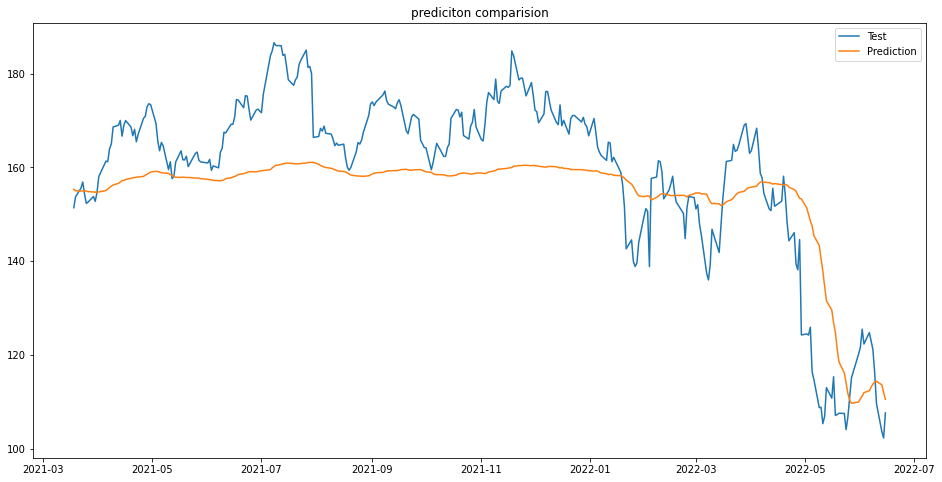

In [ ]:
import matplotlib.pyplot as plt
test_data=df['Close'][split_lim-window_size:-1]

forecast=forecast(model,test_data,window_size,batch_size)
result=forecast.squeeze()


plt.figure(figsize=(16,8))
plt.plot(test_time,X_test,label='Test')
plt.plot(test_time,result,label='Prediction')
plt.title('prediciton comparision')
plt.legend()



## Looking For the Confidence Intervals

In [ ]:
# The following code establishes a confidence interval of 90%
# We make use of GradientBoosingRegressor of
from sklearn.ensemble import GradientBoostingRegressor

LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9

N_ESTIMATORS = 100
MAX_DEPTH = 5


lower_model = GradientBoostingRegressor(
    loss="quantile", alpha=LOWER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH
)

upper_model = GradientBoostingRegressor(
    loss="quantile", alpha=UPPER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH
)

In [ ]:
#the following code extracts the numpy data from tensorflow data format and arranges them in a list

X_train=[]
y_train=[]

for data in train_set:
  for x in data:
    for num in x.numpy():
      try:
        if num.shape[0]>1:
          X_train.append(num)
      except IndexError:
        y_train.append(num)

print(f'''X_train : {X_train[:3]}\n y_train :{y_train[:3]}''')

X_train : [array([49.75    , 50.046501, 50.146999, 50.317001, 50.456501, 49.849998,
       49.330502, 49.1455  , 48.314999, 48.794998, 48.6455  , 48.621498,
       55.047501, 55.5425  , 55.264   , 55.183998, 54.710999, 55.580002,
       56.033001, 56.158501]), array([76.391998, 77.845497, 76.374496, 75.892998, 73.004501, 73.008499,
       75.898003, 78.630997, 78.306503, 79.112999, 78.484001, 78.603996,
       79.047501, 80.007004, 79.619499, 80.400002, 80.454002, 80.1455  ,
       80.077003, 78.806   ]), array([84.989998, 85.689003, 84.697998, 84.986504, 85.531502, 86.950996,
       87.153503, 87.75    , 89.831001, 90.651497, 91.124496, 92.196503,
       92.146004, 90.648499, 90.684998, 90.099998, 91.461998, 93.180496,
       90.400002, 90.863503])]
 y_train :[56.644001, 79.363998, 88.960999]


In [ ]:
#fitting the data with the train to predict the upper and lower bounds for the train data
lower_model.fit(X_train,y_train)
upper_model.fit(X_train,y_train)

GradientBoostingRegressor(loss='quantile', max_depth=5)

In [ ]:
def convert_series_to_batched_data(series,window_size,batch_size):
  '''
  This function takes in a series and returns a batched windowed data 
  '''
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda window: window.batch(window_size))
  dataset=dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
batched_test=convert_series_to_batched_data(test_data,window_size,batch_size)

X_test=[]

for dat in batched_test:
  for k in dat:
    X_test.append(k.numpy())

In [ ]:
l=lower_model.predict(X_test)

u=upper_model.predict(X_test)

assert (u>l).any()

### Plotting with Confidence bounds

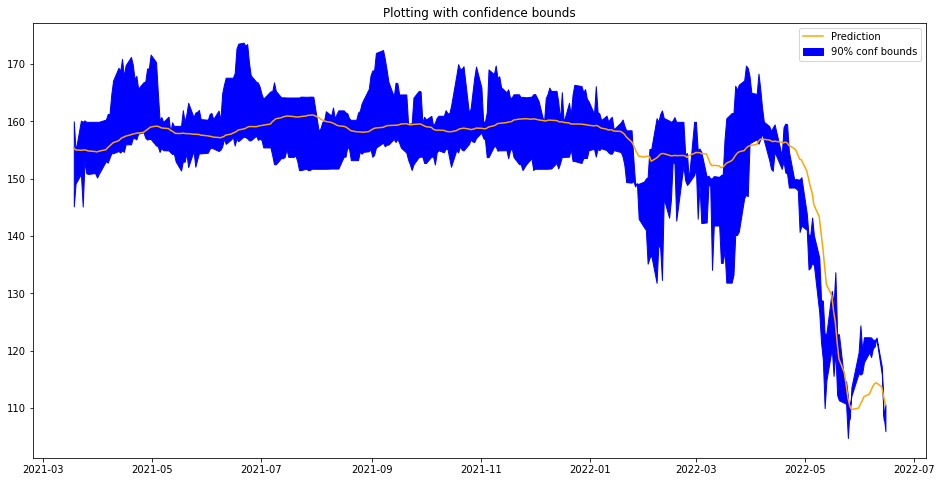

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Plotting with confidence bounds')
plt.fill_between(test_time, l, u, color='b', alpha=1,label='90% conf bounds')
plt.plot(test_time,result,color='orange',label='Prediction')
plt.legend();
